<a href="https://colab.research.google.com/github/mervegb/deep-learning/blob/main/word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import matplotlib.pyplot as plt


In [65]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
]

In [67]:
# We iterate over tokens in corpus and generate list of unique words (tokens)
def tokenize_corpus(corpus):
  tokens = [x.split() for x in corpus]
  return tokens

tokenized_corpus = tokenize_corpus(corpus)
print(tokenized_corpus)

[['he', 'is', 'a', 'king'], ['she', 'is', 'a', 'queen'], ['he', 'is', 'a', 'man'], ['she', 'is', 'a', 'woman'], ['warsaw', 'is', 'poland', 'capital'], ['berlin', 'is', 'germany', 'capital'], ['paris', 'is', 'france', 'capital']]


In [71]:
# Next, we create two dictionaries for mapping between word and index
vocabulary = []
for sentence in tokenized_corpus:
  for token in sentence:
    if token not in vocabulary:
      vocabulary.append(token)

word2idx = {w: idx for (idx,w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx,w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

print(word2idx)
print(idx2word)
print(vocabulary_size)

{'he': 0, 'is': 1, 'a': 2, 'king': 3, 'she': 4, 'queen': 5, 'man': 6, 'woman': 7, 'warsaw': 8, 'poland': 9, 'capital': 10, 'berlin': 11, 'germany': 12, 'paris': 13, 'france': 14}
{0: 'he', 1: 'is', 2: 'a', 3: 'king', 4: 'she', 5: 'queen', 6: 'man', 7: 'woman', 8: 'warsaw', 9: 'poland', 10: 'capital', 11: 'berlin', 12: 'germany', 13: 'paris', 14: 'france'}
15


In [72]:
window_size = 2  # we will use two words to the left and two words to the right
training_data = []

for sentence in tokenized_corpus:
  for idx, target_word in enumerate(sentence):
    context = []
    for w in range(-window_size, window_size + 1):
      context_idx = idx + w
      if w == 0 or context_idx < 0 or context_idx >= len(sentence):
        continue
      context_word = sentence[context_idx]
      training_data.append((target_word, context_word))

print(training_data)


[('he', 'is'), ('he', 'a'), ('is', 'he'), ('is', 'a'), ('is', 'king'), ('a', 'he'), ('a', 'is'), ('a', 'king'), ('king', 'is'), ('king', 'a'), ('she', 'is'), ('she', 'a'), ('is', 'she'), ('is', 'a'), ('is', 'queen'), ('a', 'she'), ('a', 'is'), ('a', 'queen'), ('queen', 'is'), ('queen', 'a'), ('he', 'is'), ('he', 'a'), ('is', 'he'), ('is', 'a'), ('is', 'man'), ('a', 'he'), ('a', 'is'), ('a', 'man'), ('man', 'is'), ('man', 'a'), ('she', 'is'), ('she', 'a'), ('is', 'she'), ('is', 'a'), ('is', 'woman'), ('a', 'she'), ('a', 'is'), ('a', 'woman'), ('woman', 'is'), ('woman', 'a'), ('warsaw', 'is'), ('warsaw', 'poland'), ('is', 'warsaw'), ('is', 'poland'), ('is', 'capital'), ('poland', 'warsaw'), ('poland', 'is'), ('poland', 'capital'), ('capital', 'is'), ('capital', 'poland'), ('berlin', 'is'), ('berlin', 'germany'), ('is', 'berlin'), ('is', 'germany'), ('is', 'capital'), ('germany', 'berlin'), ('germany', 'is'), ('germany', 'capital'), ('capital', 'is'), ('capital', 'germany'), ('paris', 'is

In [77]:
embedding_size = 10
learning_rate = 0.01

class SkipGram(nn.Module):
  def __init__(self, vocab_size,embedding_size):
    super(SkipGram,self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_size)
    self.linear = nn.Linear(embedding_size,vocab_size)
    self.activation_function = nn.LogSoftmax(dim=-1)

 #Output Size => vocabulary size
 #Because we are trying to predict the likelihood of each word in the vocabulary being in the context of the input word
 #so we need as many output units as there are unique words in my vocabulary


#Softmax function converts raw outputs (logits) into probabilities for each class
#This is often used in multi-class classification problems

  def forward(self,target_word):
    embedded_word = self.embeddings(target_word)
    out = self.linear(embedded_word)
    out = self.activation_function(out)
    return out

In [78]:
# Convert training data to PyTorch tensors
train_indices = torch.tensor([word2idx[w[0]] for w in training_data], dtype=torch.long)
label_indices = torch.tensor([word2idx[w[1]] for w in training_data], dtype=torch.long)

In [81]:
skip_gram_model = SkipGram(vocabulary_size, embedding_size)
criterion = nn.NLLLoss()

#Negative Log-Likelihood (NLL) Loss is commonly used in conjuction with LogSoftmax
#for classification problems. NLL Loss measures the divergence between the predicted probabilities and the actual labels

optimizer = optim.SGD(skip_gram_model.parameters(), lr=learning_rate)

In [84]:
# Function to evaluate word vectors using cosine similarity
def evaluate_word_vectors(embeddings, word1, word2, word2idx):
    idx1, idx2 = word2idx[word1], word2idx[word2]
    word_vec1 = embeddings(torch.tensor(idx1)).detach().numpy().reshape(1, -1)
    word_vec2 = embeddings(torch.tensor(idx2)).detach().numpy().reshape(1, -1)
    similarity = cosine_similarity(word_vec1, word_vec2)
    return similarity


#Cosine similarity will tell us how similar two word vectors are
#Ideally similar words should have vectors that are close to each other in the embedding space

In [110]:
# Train model and evaluate
similarity_values = []

for epoch in range(100):
    optimizer.zero_grad()
    out = skip_gram_model(train_indices)
    loss = criterion(out, label_indices)
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Evaluate every 20 epochs
    if (epoch + 1) % 20 == 0:
      sim = evaluate_word_vectors(skip_gram_model.embeddings, 'king', 'queen', word2idx)
      print(f"Cosine similarity between 'king' and 'queen': {sim[0][0]}")
      similarity_values.append(sim[0][0])


Epoch 1, Loss: 1.6213288307189941
Epoch 2, Loss: 1.6213008165359497
Epoch 3, Loss: 1.6212725639343262
Epoch 4, Loss: 1.6212445497512817
Epoch 5, Loss: 1.6212162971496582
Epoch 6, Loss: 1.6211884021759033
Epoch 7, Loss: 1.6211603879928589
Epoch 8, Loss: 1.6211323738098145
Epoch 9, Loss: 1.6211042404174805
Epoch 10, Loss: 1.6210761070251465
Epoch 11, Loss: 1.6210483312606812
Epoch 12, Loss: 1.6210200786590576
Epoch 13, Loss: 1.6209920644760132
Epoch 14, Loss: 1.6209641695022583
Epoch 15, Loss: 1.6209362745285034
Epoch 16, Loss: 1.6209081411361694
Epoch 17, Loss: 1.6208802461624146
Epoch 18, Loss: 1.6208523511886597
Epoch 19, Loss: 1.6208244562149048
Epoch 20, Loss: 1.6207964420318604
Cosine similarity between 'king' and 'queen': 0.24551686644554138
Epoch 21, Loss: 1.620768666267395
Epoch 22, Loss: 1.620740532875061
Epoch 23, Loss: 1.6207128763198853
Epoch 24, Loss: 1.6206848621368408
Epoch 25, Loss: 1.620656967163086
Epoch 26, Loss: 1.6206289529800415
Epoch 27, Loss: 1.6206014156341553
E

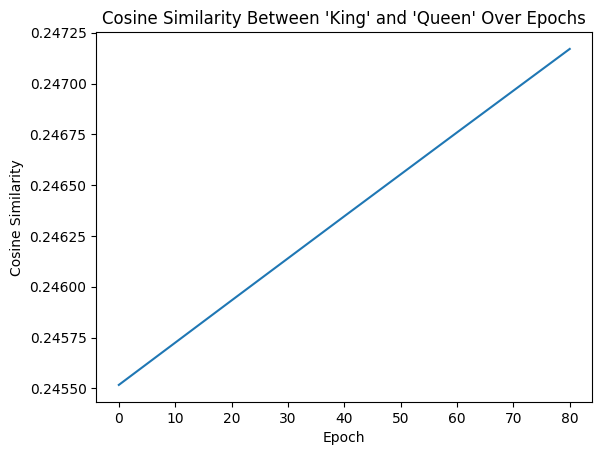

In [111]:
plt.plot(range(0, 100, 20), similarity_values)
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.title("Cosine Similarity Between 'King' and 'Queen' Over Epochs")
plt.show()

# Skip-Gram
- It is used for learning word embeddings that capture semantic meaning of words based on their context in a given text corpus

- Simple neural network with an input layer, embedding layer and an output layer

- The model takes a target word as input and tries to predict surrounding context words as output

